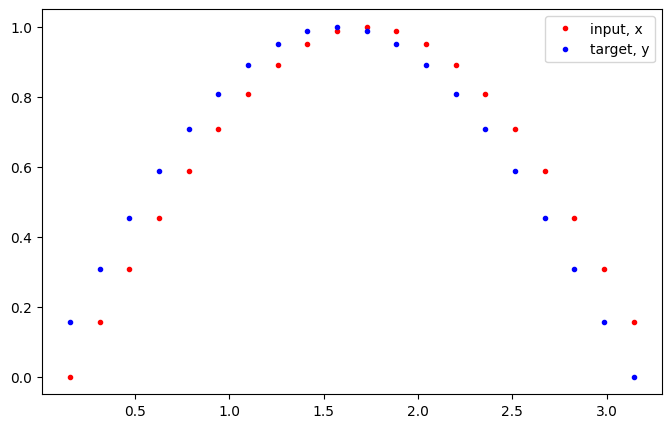

In [6]:

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# generate sample data
plt.figure(figsize=(8,5))
# how many time steps/data pts are in one batch of data
seq_length = 20
# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension
x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first
# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y
plt.legend(loc='best')
plt.show()

## Load in datasets

The datasets consist of:

    - train.csv (a training dataset)
    - test.csv (a test dataset)
    - oil.csv, transactions.csv, holidays_events.csv (exogenous datasets)
    - stores.csv (a dataset the links store information)

The data is attached in the `data` folder in the `store-sales-time-series-forecasting.zip`, and can be unzipped using the `unzip` command.

In [168]:
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_df = pd.read_csv("../../../data/train.csv")
test_df = pd.read_csv("../../../data/test.csv")
oil_df = pd.read_csv("../../../data/oil.csv")

# create sample dataset for training
# merge and reset index
train_df = train_df.merge(oil_df, on='date', how='left').dropna().set_index("id").reset_index()

# loader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=16)
def sales_by_store(data, family: str="AUTOMOTIVE", col_include = ['date', 'sales']):
    store_data = {}
    for store in data.store_nbr.unique():
        train_df = data.loc[data.family==family.upper()]
        store_data[store] = train_df.loc[train_df.store_nbr==store][col_include].sort_values(by="date", ascending=True).set_index("date")
        # create target by shifting data forward one period
        store_data[store]['sales_shift'] = store_data[store].sales.shift(-1)
        # drop remaining null position at last period
        store_data[store].dropna(inplace=True)
    return store_data

def groups_of_size(arr: np.array, n: int=20):

    chunk_indices = list(range(0, arr.size, n))
    # remove first element to prevent 0-sized first element
    chunk_indices.pop(0)
    splits = np.split(arr, chunk_indices)
    # remove last element if size is non-matching
    if splits[-1].size != n:
        splits = np.delete(splits, -1, 0)
    
    return np.vstack(splits) 

# get data for each store within sales family
store_data = sales_by_store(train_df, col_include=['date', 'sales', 'dcoilwtico'])
# for each store, append to create whole dataset

sales = np.vstack([groups_of_size(df.sales.values, n=20) for df in store_data.values()])
sales_shift = np.vstack([groups_of_size(df.sales_shift.values, n=20) for df in store_data.values()])
oil = np.vstack([groups_of_size(df.dcoilwtico.values, n=20) for df in store_data.values()])


/Users/cullenpaulisick/opt/anaconda3/envs/default_ml_dev/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [178]:
np.dstack([sales, oil])[0].shape

(20, 2)

In [165]:
train_df

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,93.14
1,1783,2013-01-02,1,BABY CARE,0.000,0,93.14
2,1784,2013-01-02,1,BEAUTY,2.000,0,93.14
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,93.14
4,1786,2013-01-02,1,BOOKS,0.000,0,93.14
...,...,...,...,...,...,...,...
2072461,3000883,2017-08-15,9,POULTRY,438.133,0,47.57
2072462,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57
2072463,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57
2072464,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57


In [164]:
from torch.utils.data import DataLoader

train_loader = DataLoader(list(zip(sales,sales_shift)), shuffle=True, batch_size=32) 
val_loader = 

tensor([0., 4., 4., 1., 4., 4., 2., 4., 1., 2., 4., 6., 1., 7., 3., 0., 2., 2.,
        1., 8.], dtype=torch.float64) tensor([4., 4., 1., 4., 4., 2., 4., 1., 2., 4., 6., 1., 7., 3., 0., 2., 2., 1.,
        8., 7.], dtype=torch.float64)
tensor([12.,  1.,  3.,  1.,  4., 10.,  9.,  5.,  1.,  1.,  5.,  3.,  2.,  1.,
         3.,  0.,  4.,  0.,  2.,  4.], dtype=torch.float64) tensor([ 1.,  3.,  1.,  4., 10.,  9.,  5.,  1.,  1.,  5.,  3.,  2.,  1.,  3.,
         0.,  4.,  0.,  2.,  4.,  2.], dtype=torch.float64)
tensor([3., 3., 8., 4., 2., 8., 3., 7., 3., 9., 6., 0., 1., 4., 4., 6., 4., 1.,
        4., 2.], dtype=torch.float64) tensor([3., 8., 4., 2., 8., 3., 7., 3., 9., 6., 0., 1., 4., 4., 6., 4., 1., 4.,
        2., 8.], dtype=torch.float64)
tensor([4., 3., 3., 5., 7., 3., 7., 9., 2., 7., 5., 4., 4., 3., 9., 9., 5., 4.,
        9., 1.], dtype=torch.float64) tensor([3., 3., 5., 7., 3., 7., 9., 2., 7., 5., 4., 4., 3., 9., 9., 5., 4., 9.,
        1., 6.], dtype=torch.float64)
tensor([5., 1., 

torch.Size([64, 20])

## Demonstrate Forward Pass

In [8]:
import sys
if ".." not in sys.path:
    sys.path.append("..")
from rnn import RNN
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2, criterion=criterion)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [9]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=2

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers, criterion=criterion)
print(rnn)

RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (criterion): MSELoss()
)


In [21]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

(21, 1)
(20, 1)
(20, 1)
Loss:  0.09375949203968048


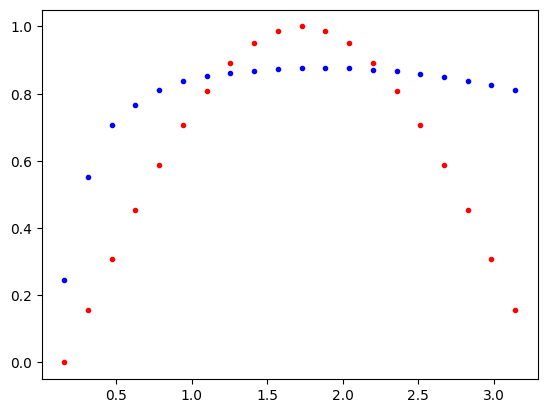

(21, 1)
(20, 1)
(20, 1)


In [24]:
n_steps = 2
print_every = 15
# train the RNN

hidden = None      
for batch_i, step in enumerate(range(n_steps)):
    # defining the training data 
    time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
    data = np.sin(time_steps)
    data.resize((seq_length + 1, 1)) # input_size=1
    print(data.shape)
    x = data[:-1]
    print(x.shape)
    y = data[1:]
    print(y.shape)
    
    # convert data into Tensors
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)

    # outputs from the rnn
    prediction, hidden = rnn(x_tensor, hidden)

    ## Representing Memory ##
    # make a new variable for hidden and detach the hidden state from its history
    # this way, we don't backpropagate through the entire history
    hidden = hidden.data

    # calculate the loss
    loss = criterion(prediction, y_tensor)
    # zero gradients
    optimizer.zero_grad()
    # perform backprop and update weights
    loss.backward()
    optimizer.step()

    # display loss and predictions
    if batch_i%print_every == 0:        
        print('Loss: ', loss.item())
        plt.plot(time_steps[1:], x, 'r.') # input
        plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
        plt.show()


In [33]:
x.shape

(20, 1)

In [32]:
x_tensor.shape

torch.Size([1, 20, 1])